In [1]:
'''
I/P -> Coder -> Unit Test -> SaveFile
'''

'\nI/P -> Coder -> Unit Test -> SaveFile\n'

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen-2.5-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 30, 'total_tokens': 40, 'completion_time': 0.05, 'prompt_time': 0.003712894, 'queue_time': 0.234892557, 'total_time': 0.053712894}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-22ce19eb-ef52-4c6d-8c9c-974ce16c7efe-0', usage_metadata={'input_tokens': 30, 'output_tokens': 10, 'total_tokens': 40})

In [8]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

class State(TypedDict):
    topic: str
    code : str
    unittest: str
    savefile: str

In [3]:
def CoderAgent(state: State):
    "Coder class to generate the code"

    msg = llm.invoke(
        """\n<instruction>:\n\n""" + \
        f"""You are a coder tasked with writing a Python code snippet based on the given '{state['topic']}'. Your task is to create a code that fulfills the requirements of the topic and adheres to best practices in Python programming based on the following criteria: \n""" + \
        """1. **Readability**: The code easy to read and understand?\n""" + \
        """2. **Adherence to Standards**: The code should follow PEP 8 or other relevant coding standards?\n""" + \
        """3. **Error Handling**: The code should not have potential errors or exceptions that are not handled?\n""" + \
        """4. **Efficiency**: The code should be efficient in terms of performance and resource usage?\n""" + \
        """5. **Maintainability**: The code structured should be in a way that is easy to maintain and extend?\n""" + \
        """</instruction>"""
        )
    return {"code": msg.content}

In [34]:
# Nodes
def CoderAgent(state: State):
    "Coder class to generate the code"

    msg = llm.invoke(
        """\n<instruction>:\n\n""" + \
        f"""You are a coder tasked with writing a Python code snippet based on the given '{state['topic']}'. Your task is to create a code that fulfills the requirements of the topic and adheres to best practices in Python programming based on the following criteria: \n""" + \
        """1. **Readability**: The code easy to read and understand?\n""" + \
        """2. **Adherence to Standards**: The code should follow PEP 8 or other relevant coding standards?\n""" + \
        """3. **Error Handling**: The code should not have potential errors or exceptions that are not handled?\n""" + \
        """4. **Efficiency**: The code should be efficient in terms of performance and resource usage?\n""" + \
        """5. **Maintainability**: The code structured should be in a way that is easy to maintain and extend?\n""" + \
        """</instruction>"""
        )
    return {"code": msg.content}

def UnitTestAgent(state: State):
    "UnitTest class to generate the unit test"
    msg = llm.invoke(
        """\n<instruction>:\n\n""" + \
        f"""You are a tester tasked with writing a unit test for the Python code snippet based on the given '{state['code']}'. Your task is to create a unit test that validates the correctness and functionality of the code based on the following criteria: \n""" + \
        """1. **Correctness**: The unit test should validate the correctness of the code?\n""" + \
        """2. **Coverage**: The unit test should cover all the possible scenarios and edge cases?\n""" + \
        """3. **Performance**: The unit test should not have performance issues or bottlenecks?\n""" + \
        """4. **Maintainability**: The unit test should be easy to maintain and extend?\n""" + \
        """Output: Give only Unittest cases nothing else\n""" + \
        """</instruction>"""
        )
    return {"unittest": msg.content}

def SaveFileAgent(state: State):
    "SaveFile class to generate the code to save the file"
    # print("UNITTEST",state['code'])
    msg = llm.invoke(
        """\n<instruction>:\n\n""" + \
        f"""You are a Python developer tasked with generating Python code to save unit tests based on the given {state['unittest']} into a file named `test_cases.py`. Please write a Python script that creates this file and writes the test cases into it. Ensure each test method is clearly named and includes relevant assertions to validate the expected behavior of the functions being tested.\n\n""" + \
        """Provide the Python code that accomplishes this task.\n""" + \
        """</instruction>"""
    )
    # Extract the test cases code from the model's output
    test_cases_code = msg.content
    
    # Write the test cases to a file
    with open('test_cases.py', 'w') as file:
        file.write(test_cases_code)

    # Check if the file was created
    if os.path.exists('test_cases.py'):
        print("File created successfully.")
    else:
        print("Failed to create the file.")
        
    return {"savefile": msg.content}
    

In [35]:
# def SaveFileAgent(state: State):
#     "SaveFile class to generate the code to save the file"
#     print("UNITTEST",state['code'])
#     msg = llm.invoke(
#         """\n<instruction>:\n\n""" + \
#         f"""You are a python developer tasked to save unit test based on the given {state['code']}. Your task is to create a code that saves the output of the code and unit test to a file based on the following criteria: \n""" + \
#         """1. **File Format**: The output should be saved in a readable format such as text or JSON or python?\n""" + \
#         """2. **Error Handling**: The code should handle file I/O errors and exceptions?\n""" + \
#         """3. **Efficiency**: The code should be efficient in terms of performance and resource usage?\n""" + \
#         """4. **Maintainability**: The code should be easy to maintain and extend?\n""" + \
#         """Output: Save unittest cases to a test.py file nothing else\n""" + \
#         """</instruction>"""
#         )
#     return {"savefile": msg.content}

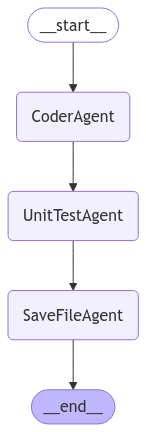

In [36]:
# Build Workflow
workflow = StateGraph(State)

# Add Nodes
workflow.add_node("CoderAgent", CoderAgent)
workflow.add_node("UnitTestAgent", UnitTestAgent)
workflow.add_node("SaveFileAgent", SaveFileAgent)

# Add Edges
workflow.add_edge(START, "CoderAgent")
workflow.add_edge("CoderAgent", "UnitTestAgent")
workflow.add_edge("UnitTestAgent", "SaveFileAgent")
workflow.add_edge("SaveFileAgent", END)

review_graph=workflow.compile()

# Show
display(Image(review_graph.get_graph().draw_mermaid_png()))


In [37]:
# Invoke
state = review_graph.invoke({"topic": "write a code to add two numbers"})

File created successfully.


In [29]:
state

{'topic': 'write a code to add two numbers',
 'code': 'Based on the instruction, here is a Python code snippet that adds two numbers, fulfilling the criteria of readability, adherence to standards, error handling, efficiency, and maintainability:\n\n```python\ndef add_two_numbers(a: float, b: float) -> float:\n    """\n    Add two numbers and return the result.\n\n    Parameters:\n    a (float): The first number to add.\n    b (float): The second number to add.\n\n    Returns:\n    float: The sum of the two numbers.\n    """\n    if not (isinstance(a, (int, float)) and isinstance(b, (int, float))):\n        raise TypeError("Both inputs must be numbers (either int or float).")\n    \n    return a + b\n\n# Example usage:\nif __name__ == "__main__":\n    try:\n        number1 = float(input("Enter the first number: "))\n        number2 = float(input("Enter the second number: "))\n        result = add_two_numbers(number1, number2)\n        print(f"The sum of {number1} and {number2} is: {res